### Blog Post: 'Optimal' Decision Making

Once again, to begin, the training data must be accessed.

In [2]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

Here's a look at the data:

In [3]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


Time to clean the data and take another look. I won't one hot encode the columns yet, because I'm going to use some of them to explore the data set.

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_train['loan_status'])

def prepare_data(df):
    df = df.drop(['loan_grade'], axis=1)
    df = df.dropna()
    y = le.fit_transform(df['loan_status'])
    df = df.drop(['loan_status'], axis = 1)

    return df, y

X_train, y_train = prepare_data(df_train)
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,RENT,3.0,EDUCATION,11750,13.47,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,10000,7.51,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,1325,12.87,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,15000,9.63,0.28,N,10
6,21,21700,RENT,2.0,HOMEIMPROVEMENT,5500,14.91,0.25,N,2


## Exploring the Data

Let's get familiar with some of the attributes and decide which ones might be helpful to predict whether someone defaulted on a loan or not.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

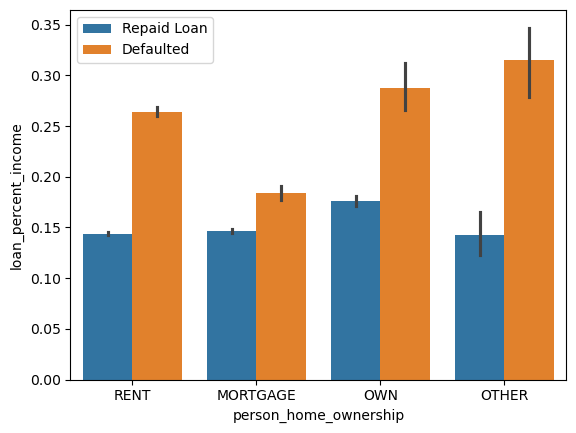

In [6]:
x = X_train['person_home_ownership']
y = X_train['loan_percent_income']

ax = sns.barplot(data=X_train, x = 'person_home_ownership', y = 'loan_percent_income', hue = y_train.astype(str))

h,l = ax.get_legend_handles_labels()
l = ["Repaid Loan", "Defaulted"]
ax.legend(h, l)

plt.show()

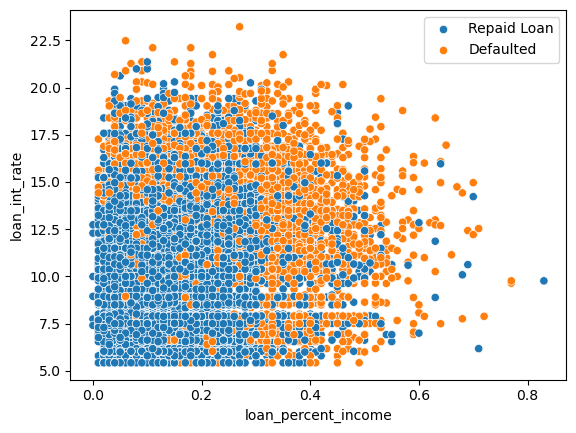

In [7]:
x = X_train['loan_percent_income']
y = X_train['loan_int_rate']

ax = sns.scatterplot(data=X_train, x = 'loan_percent_income', y = 'loan_int_rate', hue = y_train.astype(str))

h,l = ax.get_legend_handles_labels()
l = ["Repaid Loan", "Defaulted"]
ax.legend(h, l)

plt.show()

In [8]:
X_train.groupby([y_train, 'cb_person_default_on_file'])[['person_emp_length', 'cb_person_cred_hist_length']].mean()

person_emp_length  cb_person_cred_hist_length
  cb_person_default_on_file                                               
0 N                                   4.987118                    5.809296
  Y                                   4.782471                    5.928938
1 N                                   4.161868                    5.603114
  Y                                   4.166886                    5.735217

### Building a Model

Now that I'm ready to start modeling, I'll go ahead an one hot encode any qualitative columns.

In [9]:
X_train = pd.get_dummies(X_train)
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,27,98000,3.0,11750,13.47,0.12,6,0,0,0,1,0,1,0,0,0,0,0,1
2,22,36996,5.0,10000,7.51,0.27,4,0,0,0,1,0,1,0,0,0,0,1,0
3,24,26000,2.0,1325,12.87,0.05,4,0,0,0,1,0,0,0,1,0,0,1,0
4,29,53004,2.0,15000,9.63,0.28,10,1,0,0,0,0,0,1,0,0,0,1,0
6,21,21700,2.0,5500,14.91,0.25,2,0,0,0,1,0,0,1,0,0,0,1,0


I'm going to try recursive feature elimination to assign weights to different features in the training data and select the best ones.

In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()

cols = RFE(estimator, n_features_to_select=3, step=1).fit(X_train, y_train)
cols_rfe = cols.get_feature_names_out()
cols_rfe

array(['person_income', 'loan_amnt', 'loan_int_rate'], dtype=object)

In [11]:
from sklearn.model_selection import cross_val_score

lr_rfe = LogisticRegression().fit(X_train[cols_rfe], y_train)

cv_scores_rfe = cross_val_score(lr_rfe, X_train[cols_rfe], y_train, cv=5).mean()
cv_scores_rfe

0.8117172718507574

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

cols = SelectKBest(mutual_info_classif, k = 3)
cols.fit_transform(X_train, y_train)
cols_skb = cols.get_feature_names_out()
cols_skb

array(['person_income', 'loan_int_rate', 'loan_percent_income'],
      dtype=object)

In [13]:
from sklearn.model_selection import cross_val_score

lr_skb = LogisticRegression().fit(X_train[cols_skb], y_train)

cv_scores_skb = cross_val_score(lr_skb, X_train[cols_skb], y_train, cv=5).mean()
cv_scores_skb

0.8021563455835603

In [14]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.0001, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True).fit(X_train, y_train)
x_new = model.transform(X_train)
cols_svc = model.get_feature_names_out()
cols_svc

array(['person_age', 'loan_amnt', 'loan_int_rate'], dtype=object)

In [15]:
from sklearn.model_selection import cross_val_score

lr_svc = LogisticRegression().fit(X_train[cols_svc], y_train)

cv_scores_svc = cross_val_score(lr_svc, X_train[cols_svc], y_train, cv=5).mean()
cv_scores_svc

0.7949095723125648

Looks like RFE worked the best to select features so I'll stick with person_income, loan_int_rate, and loan_percent_income as the attributes for the remainder of the project.

In [16]:
w = lr_rfe.coef_.T
w

array([[-4.05735976e-05],
       [ 1.06558819e-04],
       [ 9.49045880e-08]])

In [17]:
def calc_score(X, w):
    return X@w

In [34]:
X_train['score'] = calc_score(X_train[cols_rfe], w)
X_train['score'].head(50)

1     -2.724145
2     -0.435472
3     -0.913722
4     -0.552180
6     -0.294372
7     -1.078671
8     -1.328416
9     -0.866993
10    -0.086189
11    -0.080296
12    -0.207142
13    -4.709531
14    -1.492597
15    -0.059797
16    -2.525174
17    -2.025183
18    -1.236856
19    -2.458977
20    -0.508184
21    -1.859404
22    -2.383166
23    -0.983590
24    -2.104489
25     0.116204
27    -1.457767
28    -2.093814
29    -0.827445
30    -1.850373
31    -3.275786
32    -0.108589
33    -2.864712
34    -1.135210
35     0.061924
36    -1.133178
37    -1.356546
38    -2.512256
39    -3.806445
40    -1.368826
41    -0.917605
42    -0.545074
43    -1.235283
44    -0.888178
45    -1.572517
46    -2.458977
47    -1.861047
48    -2.606534
49    -0.899814
50     0.432424
51   -11.106489
52    -3.844350
Name: score, dtype: float64

In [36]:
import numpy as np

X_train['profit'] = X_train["loan_amnt"]*(1 + 0.25*X_train["loan_int_rate"] * 0.01)**10 - X_train["loan_amnt"]
X_train['cost'] = X_train["loan_amnt"]*(1 + 0.25*X_train["loan_int_rate"] * 0.01)*3 - 1.7*X_train["loan_amnt"]

# both equal to 1 is 0
# both equal to 0 is +profit
# y_pred = 1, y_train = 0 is 0
# y_pred = 0, y_train = 1 is -cost

for t in np.linspace(0, 1, 21):
    y_pred = 1.0*(X_train['score'] > t)
    #if score <= t, they get the loan
    profit = (((y_pred != y_train) * (y_pred == 0) * -X_train['cost']) + ((y_pred == y_train) * (y_pred == 0) * X_train['profit'])).sum()
    acc = (y_pred == y_train).mean()
    print(f"A threshold of {t:.2f} gives an accuracy of {acc:.2f} and an average profit of {profit:.0f}.")

A threshold of 0.00 gives an accuracy of 0.81 and an average profit of -7866664.
A threshold of 0.05 gives an accuracy of 0.80 and an average profit of -9650146.
A threshold of 0.10 gives an accuracy of 0.80 and an average profit of -11659056.
A threshold of 0.15 gives an accuracy of 0.80 and an average profit of -13955409.
A threshold of 0.20 gives an accuracy of 0.80 and an average profit of -15162766.
A threshold of 0.25 gives an accuracy of 0.79 and an average profit of -16754399.
A threshold of 0.30 gives an accuracy of 0.79 and an average profit of -17931599.
A threshold of 0.35 gives an accuracy of 0.79 and an average profit of -19022470.
A threshold of 0.40 gives an accuracy of 0.79 and an average profit of -19671379.
A threshold of 0.45 gives an accuracy of 0.79 and an average profit of -20259539.
A threshold of 0.50 gives an accuracy of 0.79 and an average profit of -20751030.
A threshold of 0.55 gives an accuracy of 0.79 and an average profit of -21333027.
A threshold of 0.6